In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve
)

from scipy import sparse
from xgboost import XGBClassifier
import joblib

from final_preprocessing import final_common_preprocessing

## Model training by cells

In [2]:
# ---------------------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------------------
SUFFIX = "_FINAL"
BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50")

demographics_path = BASE / "demographics_opioid_sample5M.parquet"
split_spells_path = BASE / f"split_spells{SUFFIX}.parquet"
icd10_path = BASE / f"icd10_codes_from_spells{SUFFIX}_clustered.parquet"

AE_WINDOW_DAYS = 30

# ---------------------------------------------------------------------
# 2. Load data
# ---------------------------------------------------------------------
print("Loading data...")
dem = pd.read_parquet(demographics_path)
spells = pd.read_parquet(split_spells_path)
icd = pd.read_parquet(icd10_path)

df, numeric_cols, cat_cols = final_common_preprocessing(spells, dem, icd, AE_WINDOW_DAYS)

Loading data...
dem shape:    (824793, 6)
spells shape: (1791008, 14)
icd shape:    (1228607, 4)
spells after drug_combo filter: (1577817, 14)
spells after first_ae_date = entry_date filter: (1574785, 14)
spells after moving first_ae_date one day earlier: (1574785, 14)
spells after short no-AE spell filter: (928171, 14) (removed 41.06% rows)
Number of spells with AE 14462
Number of AE within 30 days: 11902
AE within 30 days rate: 0.012823068163086327
Spells before deduplication: 928171
Spells after deduplication: 847894
Number of AE within 30 days after dedup: 11896
Merging tables...
After merging demographics, df shape: (847894, 22)
Combined df shape: (847894, 23)
Number of AE within 30 days after merge: 11896
Number of rows with NaN in birthyear: 2118
Number of rows with None in gender: 0
Filtering out 905 rows (0.11%) where AE ICD prefix appears in icd10_codes (potential leakage).
Number of AE within 30 days after leakage filter: 11092
Rows remaining after leakage filter: 846989
Dro

In [3]:
# ---------------------------------------------------------------------
# 7. Multi-hot encode drugs & ICD10 groups
# ---------------------------------------------------------------------
# Ensure icd10_codes is list-like; replace NaNs with empty list
def to_list_or_empty(x):
    # already a proper list/tuple
    if isinstance(x, (list, tuple)):
        return list(x)
    
    # numpy array from parquet
    if isinstance(x, np.ndarray):
        return x.tolist()
    
    # explicit None
    if x is None:
        return []
    
    # pandas NA / NaN scalars
    try:
        if pd.isna(x):
            return []
    except TypeError:
        # pd.isna on weird types (like arrays) would error,
        # but we've already handled arrays above.
        pass
    
    # fallback: treat as single code
    return [x]

df["icd10_codes"] = df["icd10_codes"].apply(to_list_or_empty)

# drug_combo is already list-like from earlier filter
df["drug_combo"] = df["drug_combo"].apply(lambda x: list(x))

df["num_drugs_in_spell"] = df["drug_combo"].apply(len)
df["num_icd10_codes"] = df["icd10_codes"].apply(len)
numeric_cols.extend(["num_drugs_in_spell", "num_icd10_codes"])

print("Fitting MultiLabelBinarizer for drugs...")
mlb_drugs = MultiLabelBinarizer(sparse_output=True)
X_drugs = mlb_drugs.fit_transform(df["drug_combo"])

print("Number of drug classes:", len(mlb_drugs.classes_))

print("Fitting MultiLabelBinarizer for ICD10 groups...")
mlb_icd = MultiLabelBinarizer(sparse_output=True)
X_icd = mlb_icd.fit_transform(df["icd10_codes"])

print("Number of ICD10 groups:", len(mlb_icd.classes_))

# ---------------------------------------------------------------------
# 8. One-hot encode demographics & combine all features
# ---------------------------------------------------------------------
print("One-hot encoding demographics...")
X_base = df[numeric_cols + cat_cols].copy()

# Fill numeric NaNs with median
for c in numeric_cols:
    X_base[c] = X_base[c].fillna(X_base[c].median())

X_base = pd.get_dummies(X_base, columns=cat_cols, dummy_na=True)

# Make sure everything is numeric and not object
X_base = X_base.apply(pd.to_numeric, errors="coerce").fillna(0).astype("float32")

# Convert base to sparse and hstack with drugs & icd
X_base_sparse = sparse.csr_matrix(X_base.values)

print("Stacking feature matrices...")
# X = sparse.hstack([X_drugs, X_icd]).tocsr()
X = sparse.hstack([X_base_sparse, X_drugs, X_icd]).tocsr()
y = df["y"].values

print("Final feature matrix shape:", X.shape)

# ---------------------------------------------------------------------
# 9. Train/validation split (stratified)
# ---------------------------------------------------------------------
print("Splitting train/validation...")
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print(f"Train positives: {pos}, negatives: {neg}, scale_pos_weight: {scale_pos_weight:.2f}")

Fitting MultiLabelBinarizer for drugs...
Number of drug classes: 200
Fitting MultiLabelBinarizer for ICD10 groups...
Number of ICD10 groups: 1986
One-hot encoding demographics...
Stacking feature matrices...
Final feature matrix shape: (814412, 2200)
Splitting train/validation...
Train positives: 8718, negatives: 642811, scale_pos_weight: 73.73


## Evaluating the results

In [5]:
BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50")
SUFFIX = "_FINAL"

# Load model and encoders
model = joblib.load(BASE / f"xgb_ae30d_model{SUFFIX}.joblib")

print("Model loaded.")


Model loaded.


In [6]:
print(X_valid.shape, y_valid.shape)

(162883, 2200) (162883,)


In [8]:
y_valid_proba = model.predict_proba(X_valid)[:, 1]

prec, rec, thr = precision_recall_curve(y_valid, y_valid_proba)

# Remove the last threshold element (PR curve has len(thr) = len(prec) - 1)
prec = prec[:-1]
rec = rec[:-1]
thr = thr

# F1-optimal threshold
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = f1.argmax()
best_thr_f1 = thr[best_idx]

print(f"F1-max threshold: {best_thr_f1:.4f}")
print(f"Precision at F1-max: {prec[best_idx]:.4f}")
print(f"Recall at F1-max:    {rec[best_idx]:.4f}")
print(f"F1-max:              {f1[best_idx]:.4f}")

def find_threshold_for_precision(target_precision):
    # find first threshold where precision >= target_precision
    idx = np.where(prec >= target_precision)[0]
    if len(idx) == 0:
        return None
    i = idx[0]
    return thr[i], prec[i], rec[i]

for p_target in [0.05, 0.10, 0.20]:
    res = find_threshold_for_precision(p_target)
    if res is None:
        print(f"No threshold achieves precision >= {p_target}")
    else:
        t, p, r = res
        print(f"Precision ≥ {p_target:.2f}: threshold={t:.4f}, precision={p:.4f}, recall={r:.4f}")


F1-max threshold: 0.4384
Precision at F1-max: 0.0888
Recall at F1-max:    0.1431
F1-max:              0.1096
Precision ≥ 0.05: threshold=0.2929, precision=0.0500, recall=0.3372
Precision ≥ 0.10: threshold=0.4903, precision=0.1000, recall=0.0977
Precision ≥ 0.20: threshold=0.6780, precision=0.2000, recall=0.0229


In [9]:
def precision_recall_at_k(y_true, y_proba, frac):
    n = len(y_true)
    k = int(frac * n)
    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]
    precision_k = y_top.mean()            # PPV in the top frac
    recall_k = y_top.sum() / y_true.sum() # proportion of all events captured
    return precision_k, recall_k, k

for frac in [0.001,0.01, 0.05, 0.10]:
    p_k, r_k, k = precision_recall_at_k(y_valid, y_valid_proba, frac)
    print(f"Top {int(frac*100)}% (n={k}):")
    print(f"  Precision@k: {p_k:.4f}")
    print(f"  Recall@k:    {r_k:.4f}")
    print()

baseline_rate = y_valid.mean()
print("Baseline AE rate:", baseline_rate)

p_5, r_5, k_5 = precision_recall_at_k(y_valid, y_valid_proba, 0.05)
print("Enrichment in top 5%:", p_5 / baseline_rate)

Top 0% (n=162):
  Precision@k: 0.2037
  Recall@k:    0.0151

Top 1% (n=1628):
  Precision@k: 0.1050
  Recall@k:    0.0784

Top 5% (n=8144):
  Precision@k: 0.0632
  Recall@k:    0.2362

Top 10% (n=16288):
  Precision@k: 0.0472
  Recall@k:    0.3523

Baseline AE rate: 0.013383839934185888
Enrichment in top 5%: 4.724857665236748


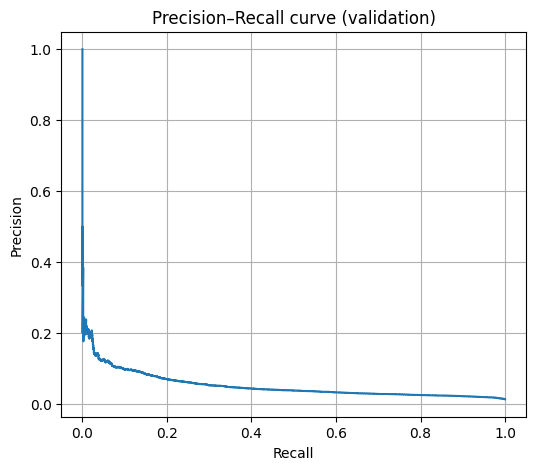

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (validation)")
plt.grid(True)
plt.show()


In [11]:
try:
    base_feature_names = X_base.columns.tolist()
except NameError:
    base_feature_names = joblib.load(BASE / "base_feature_columns.joblib")

drug_feature_names = [f"drug::{c}" for c in mlb_drugs.classes_]
icd_feature_names = [f"icd::{c}" for c in mlb_icd.classes_]

feature_names = base_feature_names + drug_feature_names + icd_feature_names
len(feature_names), X_valid.shape[1]


(2200, 2200)

In [12]:
import shap

# For Jupyter notebooks
shap.initjs()

# Sample a subset of validation rows for SHAP to keep it manageable
n_shap = min(5000, X_valid.shape[0])
rng = np.random.default_rng(42)
subset_idx = rng.choice(X_valid.shape[0], size=n_shap, replace=False)

X_valid_shap = X_valid[subset_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid_shap)

print("SHAP values shape:", np.array(shap_values).shape)


/home/bef299/bmif204/bmif204_claims_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP values shape: (5000, 2200)


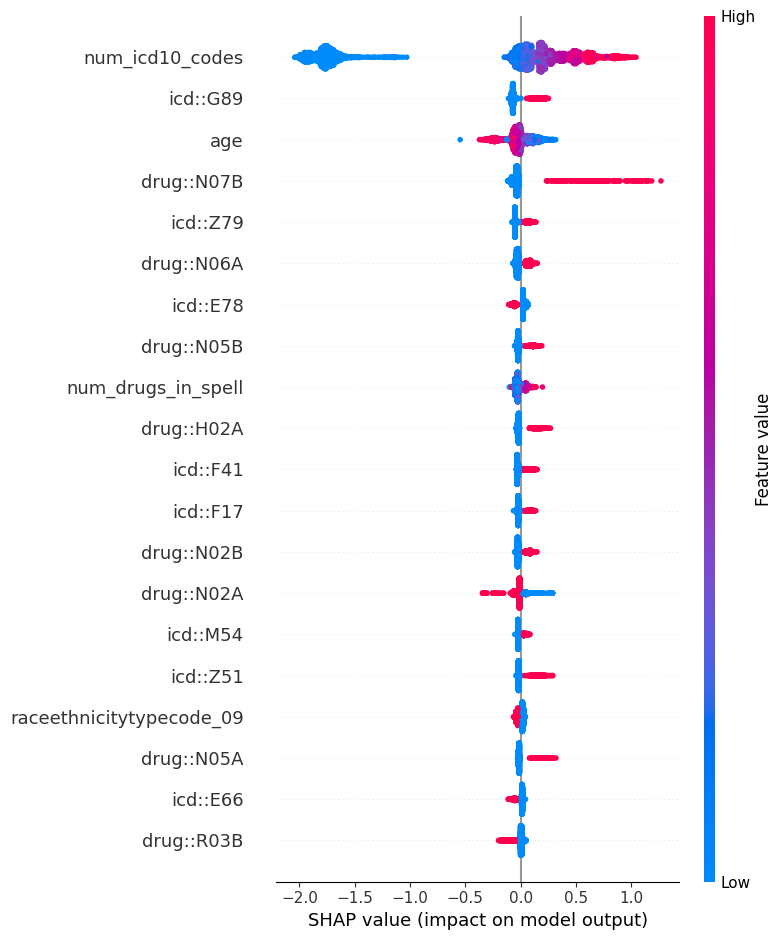

In [13]:
# Convert sparse to dense for plotting if needed (5000 x ~2000 should be OK)
X_valid_shap_dense = X_valid_shap.toarray()

shap.summary_plot(
    shap_values,
    X_valid_shap_dense,
    feature_names=feature_names,
    max_display=20
)


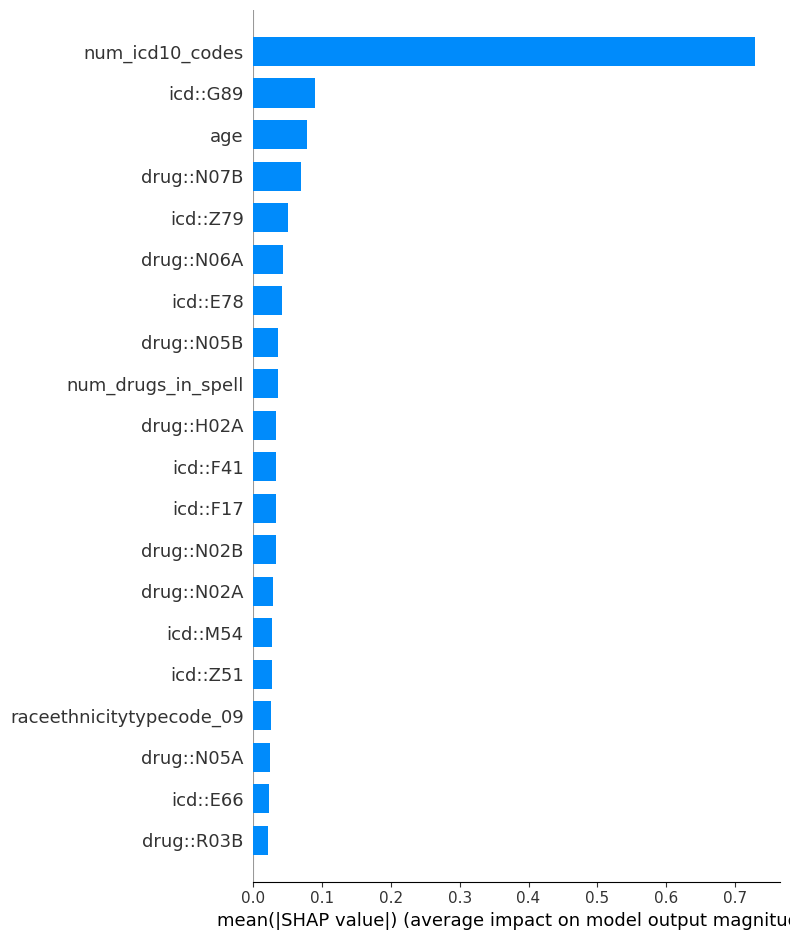

In [14]:
shap.summary_plot(
    shap_values,
    X_valid_shap_dense,
    feature_names=feature_names,
    max_display=20,
    plot_type="bar"
)
